In [1]:
%matplotlib notebook
import numpy as np
import importlib
from matplotlib import pyplot as plt
import plotutils as pu
importlib.reload(pu)

<module 'plotutils' from '/Users/koutsou/Projects/tmQCD/cA2.XX.64/0p000900/charges/plotutils.py'>

In [10]:
def plot_rati(fig, data, opts, box):
    ax = fig.add_axes(box)
    for i,dt in enumerate(data):
        ti = np.arange(dt+1, dtype=int)
        ax.errorbar(ti-dt/2+i*0.1, data[dt]['ave'], data[dt]['err'], label=r"$t_s=%da$" % dt, **opts[dt])
    return ax

def curve(ax, data, opts):
    x = data["x"]
    y = data["ave"]
    e = data["err"]
    ax.plot(x, y, **opts)
    ax.fill_between(x, y-e, y+e, **opts)
    return x

In [11]:
rati0 = {dt: pu.get_ratio("gA.h5", "set0", dt, "isov", num=False) for dt in [12,14,16]}
rati1 = {dt: pu.get_ratio("gA.h5", "set0", dt, "isov", num=True) for dt in [12,14,16]}
excit = pu.get_excifit("gA.h5", "set0", (4,25), (12,14,16), (3,-3), "isov", params=True)
plat = pu.get_ratifit("gA.h5", "set0", 16, (6,10), "isov")
opts = {12: {"color": "r", "marker": "s", "ls": ""},
        14: {"color": "g", "marker": "o", "ls": ""},
        16: {"color": "b", "marker": "D", "ls": ""},}

def twop(m, dm, a0, a1, dt):
    return a0*np.exp(-m*dt)*(1 + a1*np.exp(-dm*dt))

def thrp(m, dm, a0, a1, b0, b1, b2, ti, dt):
    return b0*np.exp(-m*dt)*(1 + b1*np.exp(-dm*(dt-ti)) + b1*np.exp(-dm*ti) + b2*np.exp(-dm*dt))

for dt in rati1:
    m,dm,a0,a1 = excit["ave"][:4]
    rati1[dt]["ave"] /= twop(m,dm,a0,a1,dt)
    m,dm,a0,a1 = excit["bin"][:, :4].T
    rati1[dt]["bin"] = (rati1[dt]["bin"].T/twop(m,dm,a0,a1,dt)).T
    rati1[dt]["err"] = rati1[dt]["bin"].std(axis=0)*np.sqrt(rati1[dt]["bin"].shape[0] - 1)

exci_curve = {}
for dt in (12,14,16):
    ti = np.linspace(3, dt-3)
    exci_curve[dt] = {}
    exci_curve[dt]["x"] = ti-dt/2
    m,dm,a0,a1,b0,b1,b2 = excit["ave"]
    exci_curve[dt]["ave"] = thrp(m,dm,a0,a1,b0,b1,b2,ti,dt)/twop(m,dm,a0,a1,dt)
    m,dm,a0,a1,b0,b1,b2 = excit["bin"].T
    ti = np.tile(np.linspace(0, dt, num=50), (excit["bin"].shape[0], 1)).T
    exci_curve[dt]["bin"] = (thrp(m,dm,a0,a1,b0,b1,b2,ti,dt)/twop(m,dm,a0,a1,dt)).T
    exci_curve[dt]["err"] = exci_curve[dt]["bin"].std(axis=0)*np.sqrt(exci_curve[dt]["bin"].shape[0]-1)

ave = excit["ave"][4]/excit["ave"][2]
err = (excit["bin"][:,4]/excit["bin"][:,2]).std(axis=0)*np.sqrt(excit["bin"].shape[0]-1)
exci_plat = {"x": [-5,5],
             "ave": np.array([ave,ave]),
             "err": np.array([err,err])}

plat = {"x": (-2,2),
        "ave": np.array([plat["ave"]]*2),
        "err": np.array([plat["err"]]*2),}

Left plot:

$$
R(t_{ins},t_s) = \frac{C^{3pt}(t_{ins},t_s)}{C^{2pt}(t_s)}
$$

where $C^{3pt}$ and $C^{2pt}$ are the three- and two-point functions from lattice data.

---

Right plot:

$$
R(t_{ins},t_s) = \frac{C^{3pt}(t_{ins},t_s)}{f^{2pt}(t_s)}
$$

where:

$$
f^{2pt}(t_s) = c_0e^{-mt_s}(1 + c_1e^{-\delta m t_s})
$$

and where $m$, $\delta m$, $c_0$ and $c_1$ are determined in the "two-state fit", i.e. by simultaneously fitting $C^{2pt}(t_s)$ and $C^{3pt}(t_{ins},t_s)$ to $f^{2pt}(t_s)$ and $f^{3pt}(t_{ins},t_s)$, where:

$$
f^{3pt}(t_{ins},t_s) = a_0e^{-mt_s}(1+a_1e^{-\delta m (t_s-t_{ins})}+a_1e^{-\delta m t_{ins}} + a_2e^{-\delta m t_s}).
$$

<IPython.core.display.Javascript object>


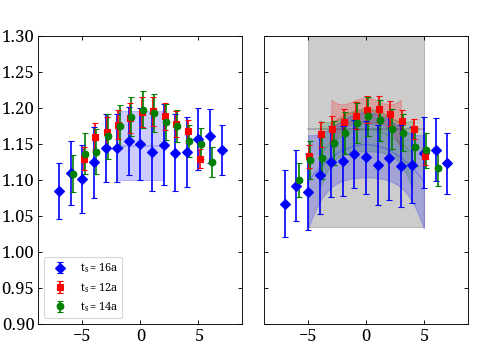

In [13]:
fig = plt.figure(1)
fig.clf()

ax0 = plot_rati(fig, rati0, opts, [0.08, 0.1, 0.425, 0.8])
ax1 = plot_rati(fig, rati1, opts, [0.55, 0.1, 0.425, 0.8])
ax0.legend(loc="lower left")
curve(ax1, exci_plat, {"color": "k", "alpha": 0.2})
curve(ax0, plat, {"color": opts[16]["color"], "alpha": 0.2})
for dt in (12,14,16):
    curve(ax1, exci_curve[dt], {"color": opts[dt]["color"], "alpha": 0.2})

for ax in [ax0,ax1]:
    ax.set_ylim(0.9, 1.3)
    
ax1.set_yticklabels([])
fig.show()

In the left plot, the red squares with errorbars are fits to the plateau method. The large blue squares without errorbars are obtained as:

$$
p(t_s) = f^{3pt}(\frac{t_s}{2}, t_s)/f^{2pt}(t_s),
$$

i.e. it is the mid-point of the plateau with sink-source separation $t_s$ based on a two-state fit to the available data.

In the right plot, the result of the two-state fit is shown as a function of the initial time-slice used in the fit of the two-point function. 

<IPython.core.display.Javascript object>


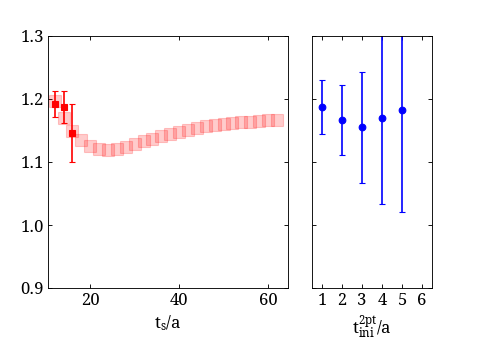

In [15]:
fig = plt.figure(2)
fig.clf()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.7])
for dt in (12,14,16):
    plat = pu.get_ratifit("gA.h5", "set0", dt, (5,dt-5), "isov")
    ax.errorbar(dt, plat["ave"], plat["err"], color="r", marker="s", ls="")

excit = pu.get_excifit("gA.h5", "set0", (4,25), (12,14,16), (3,-3), "isov", params=True)
m,dm,a0,a1,b0,b1,b2 = excit["ave"]
me,dme,a0e,a1e,b0e,b1e,b2e = excit["err"]

for dt in range(12,64,2):
    ti = np.linspace(3, dt-3)
    prms = m,dm,a0,a1,b0,b1,b2,
    ave = thrp(*prms, ti, dt)/twop(*prms[:4],dt)
    ave = ave[25]
    ax.plot(dt, ave, ms=10, marker="s", alpha=0.2, color="r")

ax.set_ylim(0.9, 1.3)
ax.set_xlim(left=10.5)
ax.set_xlabel(r"$t_s/a$")
    
ax = fig.add_axes([0.65, 0.2, 0.25, 0.7])
for ti in range(1,6):
    excit = pu.get_excifit("gA.h5", "set0", (ti,25), (12,14,16), (3,-3), "isov", params=False)
    ave = excit["ave"]
    err = excit["err"]
    ax.errorbar(ti, ave, err, marker="o", color="b")

ax.set_xlabel(r"$t^{2pt}_{ini}/a$")    
ax.set_ylim(0.9, 1.3)
ax.set_xlim(0.5,6.5)
ax.set_xticks(range(1,7))
ax.set_yticklabels([])
fig.show()

In [6]:
exci = {}
for twop_fr in [(i,j) for i in range(1,7) for j in (20,25)]:
    for dts in [(12,14,16),(14,16),(12,14)]:
        for tin in (1,2,3):
            x = pu.get_excifit("gA.h5", "set0", twop_fr, dts, (tin,-tin), params=True)
            if x is not None:
                exci[twop_fr, dts, tin] = x
            

In [7]:
vals = [v for v in exci.values()]
aves = np.array([v["ave"][4]/v["ave"][2] for v in vals])
chis = np.array([v["chi"] for v in vals])

This is the distribution of values obtained for $g_A$ using the two-state fit, when varying:
- The initial time-slice of the two-point function fit from 1a to 6a
- The distance from source and sink when fitting the three-point function: 1, 2, and 3
- The sink-source separations included: (12,14,16), (14,16), and (12,14)

and when constraining $\chi^2/d.o.f$ to be between 0 and 2

<IPython.core.display.Javascript object>


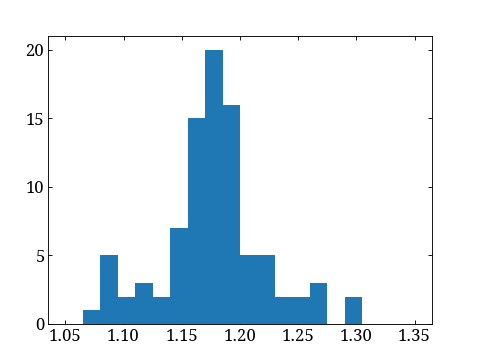

In [20]:
fig = plt.figure(3)
fig.clf()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
cut = 1
av = aves[(np.abs(chis-1)<cut)]
hi,ed = np.histogram(av, range=(1.05,1.35), bins=20, normed=False)
ax.bar((ed[1:]+ed[:-1])/2, hi, width=0.015, alpha=1,zorder=i)
fig.show()